In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install numpy scikit-learn
!pip install -q torch_geometric
!pip install -q class_resolver
!pip3 install pymatting
!pip install opencv-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.7/54.7 kB 2.2 MB/s eta 0:00:00


In [3]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss
from sklearn.model_selection import StratifiedShuffleSplit
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [4]:
# Load CN and MCI feature data
cn_path = "/content/drive/MyDrive/TejaswiAbburi_va797/Dataset/ISBI_ADNI_CN_dataset/Processed_histogram_features_CN/Histogram_feature_CN_FA_20bin.npy"
mci_path = "/content/drive/MyDrive/TejaswiAbburi_va797/Dataset/ISBI_ADNI_MCI_dataset/Processed_histogram_features_MCI/Histogram_feature_MCI_FA_20bin.npy"

cn_data = np.load(cn_path, allow_pickle=True).item()
mci_data = np.load(mci_path, allow_pickle=True).item()

In [5]:
X_cn = np.array(list(cn_data.values()))
X_mci = np.array(list(mci_data.values()))

y_cn = np.zeros(X_cn.shape[0])   # CN = 0
y_mci = np.ones(X_mci.shape[0])  # MCI = 1

# Combine data
X = np.vstack((X_cn, X_mci))
y = np.hstack((y_cn, y_mci))

In [6]:
np.random.seed(42)
perm = np.random.permutation(X.shape[0])
X = X[perm]
y = y[perm]

In [7]:
# Standardize
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [8]:
# 20 Stratified Shuffle Splits
sss = StratifiedShuffleSplit(n_splits=20, test_size=0.9, random_state=42)

In [9]:
# Storage for metrics
accuracies, precisions, recalls, f1_scores, losses = [], [], [], [], []

In [10]:
all_y_true = []
all_y_proba = []
all_fpr = []
all_tpr = []
all_auc = []
# Cross-validation loop
for fold, (train_idx, test_idx) in enumerate(sss.split(X, y)):
    print(f"\nTraining fold {fold + 1}")

    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # MLP model (tuned for performance)
    mlp = MLPClassifier(hidden_layer_sizes=(512,),
                        activation='relu', solver='adam',
                        alpha=1e-3, max_iter=1000, random_state=42)

    mlp.fit(X_train, y_train)

    y_pred = mlp.predict(X_test)
    y_pred_proba = mlp.predict_proba(X_test)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    loss = log_loss(y_test, y_pred_proba)
    auc_score = roc_auc_score(y_test, y_pred_proba)

    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)
    losses.append(loss)
    all_y_true.extend(y_test)
    all_y_proba.extend(y_pred_proba)

    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    all_fpr.append(fpr)
    all_tpr.append(tpr)
    all_auc.append(auc_score)

    print(f"Accuracy: {accuracy:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f} | F1: {f1:.4f} | Loss: {loss:.4f} | AUC: {auc_score:.4f}")

# Final average results
print("\nAverage Results across 20 folds:")
print(f"Accuracy: {np.mean(accuracies):.4f} ± {np.std(accuracies):.4f}")
print(f"Precision: {np.mean(precisions):.4f} ± {np.std(precisions):.4f}")
print(f"Recall: {np.mean(recalls):.4f} ± {np.std(recalls):.4f}")
print(f"F1 Score: {np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}")
print(f"Cross-Entropy Loss: {np.mean(losses):.4f} ± {np.std(losses):.4f}")
print(f"Average AUC: {np.mean(all_auc):.4f} ± {np.std(all_auc):.4f}")


Training fold 1
Accuracy: 0.7630 | Precision: 0.7829 | Recall: 0.7933 | F1: 0.7881 | Loss: 0.6589 | AUC: 0.8006

Training fold 2
Accuracy: 0.7370 | Precision: 0.7516 | Recall: 0.7867 | F1: 0.7687 | Loss: 0.6416 | AUC: 0.7808

Training fold 3
Accuracy: 0.7222 | Precision: 0.7389 | Recall: 0.7733 | F1: 0.7557 | Loss: 0.6661 | AUC: 0.7691

Training fold 4
Accuracy: 0.7444 | Precision: 0.7580 | Recall: 0.7933 | F1: 0.7752 | Loss: 0.6393 | AUC: 0.8194

Training fold 5
Accuracy: 0.7259 | Precision: 0.7346 | Recall: 0.7933 | F1: 0.7628 | Loss: 1.0539 | AUC: 0.7409

Training fold 6
Accuracy: 0.7185 | Precision: 0.7606 | Recall: 0.7200 | F1: 0.7397 | Loss: 0.7664 | AUC: 0.7662

Training fold 7
Accuracy: 0.7444 | Precision: 0.7832 | Recall: 0.7467 | F1: 0.7645 | Loss: 0.7359 | AUC: 0.7943

Training fold 8
Accuracy: 0.7815 | Precision: 0.7542 | Recall: 0.9000 | F1: 0.8207 | Loss: 0.6055 | AUC: 0.8113

Training fold 9
Accuracy: 0.6667 | Precision: 0.7174 | Recall: 0.6600 | F1: 0.6875 | Loss: 0.88

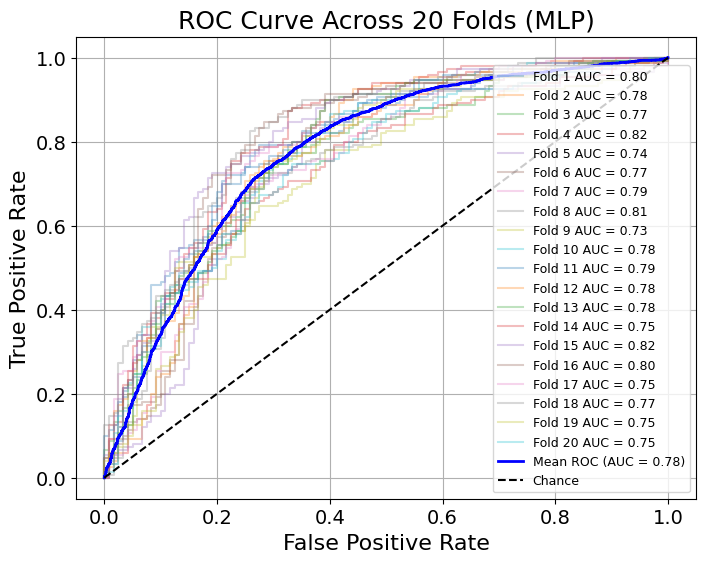

In [11]:
plt.figure(figsize=(8, 6))

for i in range(len(all_fpr)):
    plt.plot(all_fpr[i], all_tpr[i], alpha=0.3, label=f"Fold {i+1} AUC = {all_auc[i]:.2f}")

# Average ROC Curve
fpr_avg, tpr_avg, _ = roc_curve(all_y_true, all_y_proba)
auc_avg = roc_auc_score(all_y_true, all_y_proba)
plt.plot(fpr_avg, tpr_avg, color='blue', lw=2, label=f"Mean ROC (AUC = {auc_avg:.2f})")

# Diagonal line
plt.plot([0, 1], [0, 1], 'k--', label="Chance")
plt.xlabel("False Positive Rate", fontsize=16)
plt.ylabel("True Positive Rate", fontsize=16)
plt.title("ROC Curve Across 20 Folds (MLP)", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc="lower right", fontsize=9)
plt.grid(True)